In [1]:
import tensorflow as tf
import keras.preprocessing.image as process_im
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import functools
import IPython.display
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt

c:\Users\subha\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ModuleNotFoundError: No module named 'google.colab'

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls "/content/drive/My Drive"


 1931167.pdf					'Muhammad Subhan Khurshid Resume.docx'
'1931167 subhan khurshid urdu.pdf'		 procom23_first_submission.ipynb
'CamScanner 09-16-2021 20.34.pdf'		 procom23.ipynb
 Classroom					'RS ASSIGNMENT # 01.gdoc'
'Colab Notebooks'				 Subhan_Resume.pdf
'Getting started.pdf'				 TamilContentImages
'Jay_Shetty_Find_Your_Purpose_Booklet (1).pdf'	 TamilStyleImages
'Khatta !.gsheet'


In [5]:
def load_file(image_path):
  image = Image.open(image_path)
  max_dim=512
  factor=max_dim/max(image.size)
  image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)
  im_array = process_im.img_to_array(image)
  im_array = np.expand_dims(im_array,axis=0) #

  return im_array


In [7]:
def show_im(img,title=None):
  img=np.squeeze(img,axis=0)
  plt.imshow(np.uint8(img))
  if title is None:
    pass
  else:
    plt.title(title)
    plt.imshow(np.uint8(img))

In [6]:
plt.figure(figsize=(10,10))
content = load_file("/content/drive/MyDrive/TamilContentImages/C_image4.jpg")
style = load_file("/content/drive/MyDrive/TamilStyleImages/S_image4.jpg")

plt.subplot(1,2,1)
show_im(content,'Content Image')
plt.subplot(1,2,2)
show_im(style,'Style Image')
plt.show()

NameError: name 'load_file' is not defined

<Figure size 1000x1000 with 0 Axes>

In [31]:
def img_preprocess(img_path):
  image=load_file(img_path)
  img=tf.keras.applications.vgg19.preprocess_input(image)
  return img

In [32]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [33]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
'block2_conv1',
'block3_conv1',
'block4_conv1',
'block5_conv1']

In [34]:
number_content=len(content_layers)
number_style =len(style_layers)

In [35]:
def get_model():
  vgg=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
  vgg.trainable=False
  content_output=[vgg.get_layer(layer).output for layer in content_layers]
  style_output=[vgg.get_layer(layer).output for layer in style_layers]
  model_output= style_output+content_output
  return models.Model(vgg.input,model_output)

In [36]:
def get_content_loss(noise,target):
  loss = tf.reduce_mean(tf.square(noise-target))
  return loss

In [37]:
def gram_matrix(tensor):
  channels=int(tensor.shape[-1])
  vector=tf.reshape(tensor,[-1,channels])
  n=tf.shape(vector)[0]
  gram_matrix=tf.matmul(vector,vector,transpose_a=True)
  return gram_matrix/tf.cast(n,tf.float32)

In [38]:
def get_style_loss(noise,target):
  gram_noise=gram_matrix(noise)
  loss=tf.reduce_mean(tf.square(target-gram_noise))
  return loss

In [39]:
def get_features(model,content_path,style_path):
  content_img=img_preprocess(content_path)
  style_image=img_preprocess(style_path)
  content_output=model(content_img)
  style_output=model(style_image)
  content_feature = [layer[0] for layer in content_output[number_style:]]
  style_feature = [layer[0] for layer in style_output[:number_style]]
  return content_feature,style_feature

In [40]:
def compute_loss(model, loss_weights,image, gram_style_features,content_features):
  style_weight,content_weight = loss_weights
  output=model(image)
  content_loss=0
  style_loss=0
  noise_style_features = output[:number_style]
  noise_content_feature = output[number_style:]
  weight_per_layer = 1.0/float(number_style)
  for a,b in zip(gram_style_features,noise_style_features):
    style_loss+=weight_per_layer*get_style_loss(b[0],a)
  weight_per_layer =1.0/ float(number_content)
  for a,b in zip(noise_content_feature,content_features):
    content_loss+=weight_per_layer*get_content_loss(a[0],b)
  style_loss *= style_weight
  content_loss *= content_weight
  total_loss = content_loss + style_loss
  return total_loss,style_loss,content_loss

In [41]:
def compute_grads(dictionary):
  with tf.GradientTape() as tape:
    all_loss=compute_loss(**dictionary)
  total_loss=all_loss[0]
  return tape.gradient(total_loss,dictionary['image']),all_loss

In [42]:
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [5]:
def run_style_transfer(content_path,style_path,epochs=500,content_weight=1e3,style_weight=1e-2):
  model=get_model()
  for layer in model.layers:
    layer.trainable = False
  content_feature,style_feature = get_features(model,content_path,style_path)
  style_gram_matrix=[gram_matrix(feature) for feature in style_feature]
  noise = img_preprocess(content_path)
  noise=tf.Variable(noise,dtype=tf.float32)
  optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99,epsilon=1e-1)
  best_loss,best_img=float('inf'),None
  loss_weights = (style_weight, content_weight)
  dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means
  imgs = []
  for i in range(epochs):
    grad,all_loss=compute_grads(dictionary)
    total_loss,style_loss,content_loss=all_loss
    optimizer.apply_gradients([(grad,noise)])
    clipped=tf.clip_by_value(noise,min_vals,max_vals)
    noise.assign(clipped)
    if total_loss<best_loss:
      best_loss = total_loss
      best_img = deprocess_img(noise.numpy())
    if i%5==0:
      plot_img = noise.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Epoch: {}'.format(i))
      print('Total loss: {:.4e}, '
      'style loss: {:.4e}, '
      'content loss: {:.4e}, '.format(total_loss, style_loss,content_loss))
  IPython.display.clear_output(wait=True)
  return best_img,best_loss,imgs

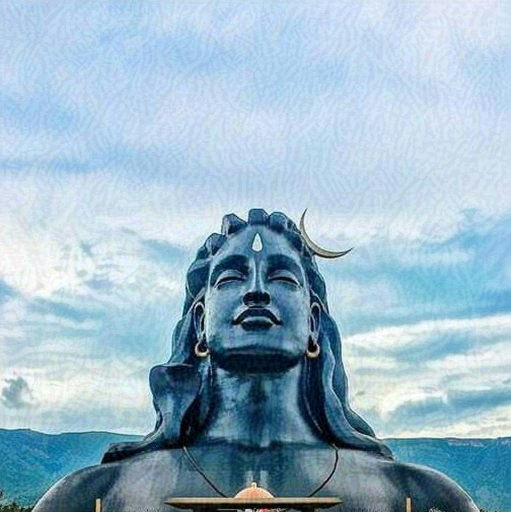

Epoch: 0
Total loss: 4.3840e+07, style loss: 4.3840e+07, content loss: 0.0000e+00, 


In [ ]:
best, best_loss,image = run_style_transfer("/content/drive/MyDrive/TamilContentImages/C_image4.jpg","/content/drive/MyDrive/TamilStyleImages/S_image4.jpg", epochs=500)

NameError: name 'best' is not defined

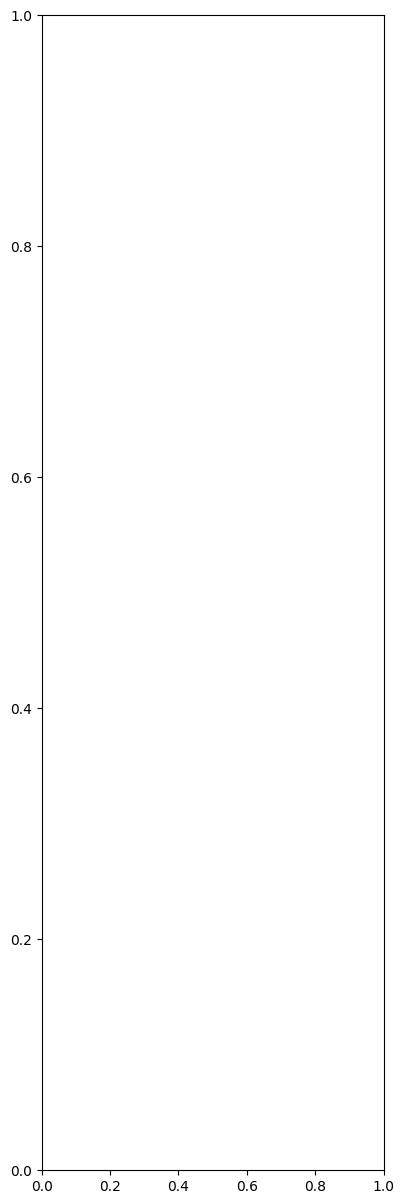

In [4]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,3)
plt.imshow(best)

plt.title('Style transfer Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,1)

show_im(content,'Content Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)

show_im(style,'Style Image')
plt.xticks([])
plt.yticks([])
plt.show()